In [1]:
import sys
import os
import json
import regex as re
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2').cuda()

In [2]:
gsm8k_train10 = [
    "In Professor Plum's biology class there are 40 students. Of those students, 80 percent have puppies. Of those who have puppies, 25% also have parrots. How many students have both puppies and parrots?",
    "Diane bought twenty more apples than Cecile. If Cecile bought 15 apples, how many apples did they buy altogether?",
    "Ann can skate 6 miles an hour. Her friend Glenda can skate 8 miles an hour. If they start in the same place and skate in straight lines in opposite directions for 3 hours, how many miles apart do they end up?",
    "Running for 2 hours, Jonah burnt 30 calories every hour. How many more calories would he have lost if he would have run for five hours?",
    "The city of Richmond has 1000 more people than Victoria. Victoria has 4 times as many people as Beacon. If Richmond has 3000 people, how many people are there in Beacon?",
    "To get his fill of oysters, Crabby has to eat at least twice as many oysters as Squido does. If Squido eats 200 oysters, how many oysters do they eat altogether?",
    "John sells 20 woodburning for $15 each.  The wood cost $100.  How much does he make in profit?",
    "In a field of 500 clovers, 20% have four leaves and one quarter of these are purple clovers. Assuming these proportions are exactly correct, how many clovers in the field are both purple and four-leaved?",
    "Tony lifts weights as a form of exercise.  He can lift 90 pounds with one arm in the exercise known as \"the curl.\"  In an exercise known as \"the military press,\" he can lift over his head twice the weight that he can curl.  His favorite exercise is known as \"the squat\" and he can squat 5 times the weight that he can lift in the military press.  How much weight, in pounds, can Tony lift in the squat exercise?",
    "Elsa started the day with 40 marbles.  At breakfast, she lost 3 marbles while playing.  At lunchtime, she gave her best friend Susie 5 marbles.  In the afternoon, Elsa's mom bought her a new bag with 12 marbles.  Susie came back and gave Elsa twice as many marbles as she received at lunch.  How many marbles did Elsa end the day with?"
]

In [3]:
def random_instructions(filename, size):
    with open(filename) as f:
        if filename.endswith('jsonl'):
            data = []
            for line in f:
                data.append(json.loads(line.strip()))
        else:
            data = json.load(f)
    
    np.random.seed(42)
    samples = np.random.choice(data, size=size, replace=False)
    instructions = []
    for sample in samples:
        if 'synthesized' in filename:
            instruction = sample['original_instruction']
        elif 'math' in filename:
            instruction = sample['problem']
        else:
            instruction = sample['question']
        
        instructions.append(instruction)
        
    return instructions

In [4]:
def mean_pooling(model_output, attention_mask):
    # First element of model_output contains all token embeddings
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, dim=1) / torch.clamp(torch.sum(input_mask_expanded, dim=1), min=1e-9)

@torch.no_grad()
def get_text_representation(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to('cuda')
    with torch.no_grad():
        output = model(**inputs)
    text_embeddings = mean_pooling(output, inputs['attention_mask'])
    
    # Normalize embeddings
    text_embeddings = F.normalize(text_embeddings, p=2, dim=1)
    return text_embeddings.cpu().numpy()

In [5]:
def random_instruction_representation(filename, size=100):
    instructions = random_instructions(filename, size=size)
    instruction_representations = get_text_representation(instructions)
    return instruction_representations

In [6]:
real_reps = random_instruction_representation('gsm8k_train.jsonl')
syn_reps = random_instruction_representation('../../data/ada-instruct/gsm8k_synthesized_10k.jsonl')
math_reps = random_instruction_representation('math_test.jsonl')
train_reps = get_text_representation(gsm8k_train10)

In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=15).fit_transform(np.concatenate([math_reps, syn_reps, real_reps, train_reps], axis=0))
math_tsne, syn_tsne, real_tsne, train_tsne = tsne[:100], tsne[100: 200], tsne[200: 300], tsne[300:]

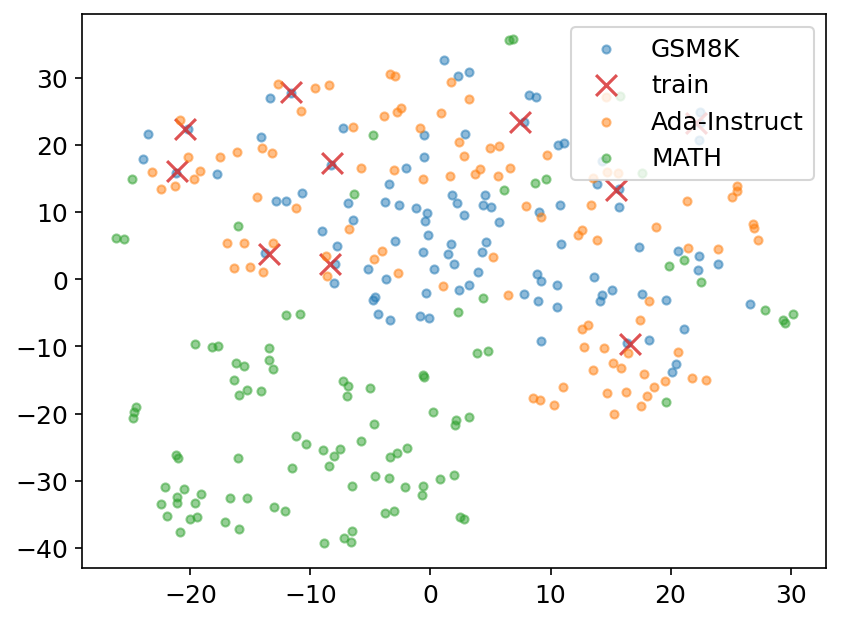

In [8]:
fig = plt.figure(dpi=150)
plt.scatter(real_tsne[:, 0], real_tsne[:, 1], label='GSM8K', alpha=0.5, s=15)
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], label='train', alpha=0.8, s=100, marker='x', c='#d62728')
plt.scatter(syn_tsne[:, 0], syn_tsne[:, 1], label='Ada-Instruct', alpha=0.5, s=15)
plt.scatter(math_tsne[:, 0], math_tsne[:, 1], label='MATH', alpha=0.5, s=15)
plt.tick_params(labelsize=12)
plt.legend(loc='upper right', prop={'size': 12})
plt.show()